# 1. Imports

In [1]:
import csv
import random
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 2. Global Variables

In [2]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

# 3. Load the Data

In [3]:
SENTIMENT_CSV = "./data/training_cleaned.csv"

In [4]:
# The labels are originally encoded as strings ('0' representing negative and '4' representing positive). 
# So I need to change this so that the labels are integers and 0 is used for representing negative, while 1 should represent positive.

def parse_data_from_file(filename):
    
    sentences = []
    labels = []
    
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        
        for item in reader:
            sentences.append(item[5])
            if (int(item[0]) > 0):
                labels.append(int(item[0]) - 3)
            else:
                labels.append(int(item[0]))
        
    return sentences, labels

sentences, labels = parse_data_from_file(SENTIMENT_CSV)

# 4. Shuffling the Data

In [5]:
# Bundle the two lists into a single one
sentences_and_labels = list(zip(sentences, labels))

# Perform random sampling
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

# Unpack back into separate lists
sentences, labels = zip(*sentences_and_labels)

# 5. Splitting the Data

In [6]:
def train_val_split(sentences, labels, training_split):
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(labels) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [7]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

# 6. Tokenization

In [8]:
def fit_tokenizer(train_sentences, oov_token):
    # Instantiate the Tokenizer class, passing in the correct values for oov_token
    tokenizer = Tokenizer(oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [9]:
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

In [10]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, padding=padding, truncating=truncating, maxlen=maxlen)
    
    return pad_trunc_sequences

In [11]:
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

In [12]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# 7. Using Pre-defined Embeddings

In [14]:
# https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt/
GLOVE_FILE = './data/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [15]:
print(f"Each word vector has shape: {GLOVE_EMBEDDINGS['dog'].shape}")

Each word vector has shape: (100,)


# 8. Representing the words in your vocabulary using the embeddings

In [16]:
# If a word in your vocabulary is NOT present in GLOVE_EMBEDDINGS then the representation of that word is left as a column of zeros
# word_index starts counting at 1, because of this we need to add an extra column at the left-most side of the EMBEDDINGS_MATRIX array
# This is the reason why we add 1 to VOCAB_SIZE below:

# Initialize an empty numpy array with the appopriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for each word exists within GloVe's representations, 
# then save it in the EMBEDDINGS_MATRIX
for word, i in word_index.items():
    embeddings_vector = GLOVE_EMBEDDINGS.get(word)
    if embeddings_vector is not None:
        EMBEDDINGS_MATRIX[i] = embeddings_vector

# Now your pre-trained embeddings is ready to use!

# 9. Define a Model that does not overfit

In [22]:
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False), 
        tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Conv1D(32, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    model.summary()

    return model

In [23]:
# Create your untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

# Train the model and save the training history
history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           12829400  
                                                                 
 dropout (Dropout)           (None, 16, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 12, 32)            16032     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                        

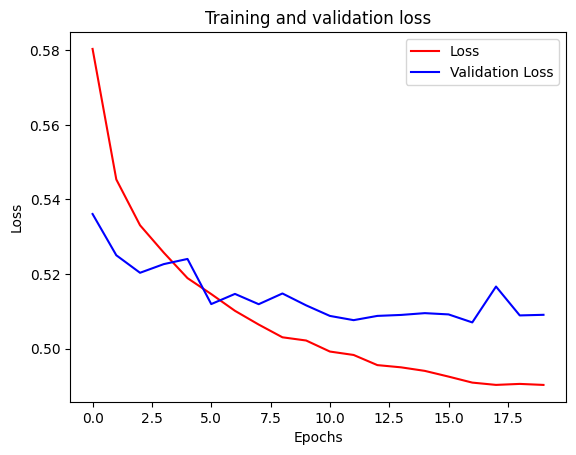

In [24]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

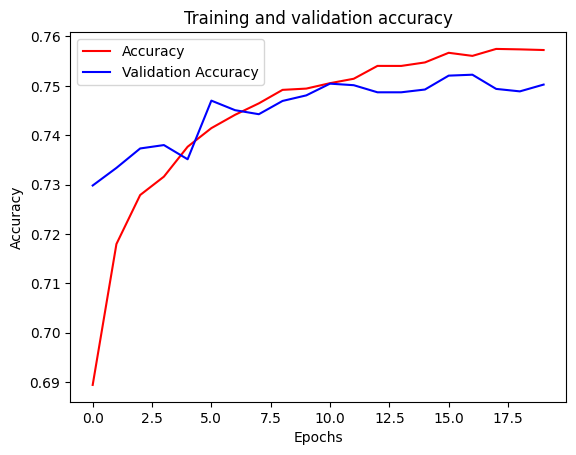

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [26]:
# Test the slope of your val_loss curve
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.00099
